# preliminaries

## load packages

In [238]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

#file system
import os
import glob

#data handling
import numpy as np
import pandas as pd
import pickle

#plotting
import seaborn as sns 
import matplotlib as mpl
import matplotlib.pyplot as plt

# custom code
from src import features, annotation, parameters, segmentation, spectrogramming


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## define path variables

In [4]:
#paths to raw data
all_wav_raw = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/raw/development/'
all_wav_bw_po_cf = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/raw/bw_po_cf/'
all_wav_bw_po_f1 = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/raw/bw_po_f1/'
all_wav_bw_po_f2 = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/raw/bw_po_f2/'

#paths to clips for developmental dataset
all_voc_clips_dirs = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/clips/amplitude_segmented/development/final_20220817/vocalization_clips/'
all_bg_clips_dirs = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/clips/amplitude_segmented/development/final_20220817/background_clips/'

#root directory for all of the segments (start and stop times)
segments_root = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/segments/'
clips_root = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/clips/'
specs_root = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/features/spectrograms/'
noise_root = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/noise/'
snr_clipping_root = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/features/snr_clipping/amplitude_segmented/'
models_root = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/models/random_forest/'
noise_floors_path = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/noise/all_noise_floors.csv'

#csv of annotated segments (start and stop times) from the development dataset
test_set_path = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/annotated/annotations_csv/all_annotations.csv'

#amplitdue segments
amplitude_acoustic_features = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/features/acoustic_features/amplitude_segmented/development/20220913_063001/'
amplitude_umap = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/features/spectrograms/amplitude_segmented/final/umap_coordinates/'
amplitude_umap_HDBSCAN_labeled = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/models/das/annotations_from_umap/'
amplitude_segments_csv = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/segments/amplitude_segmented/final/all_predictions.csv'
amplitude_voc_clips = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/clips/amplitude_segmented/development/final_20220817/vocalization_clips/'
amplitude_bg_clips = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/clips/amplitude_segmented/development/final_20220817/background_clips/'



# Figure 1

## color UMAP by HDBSCAN cluster (Figure 1C top)

### collect UMAP data

In [4]:
#choose the directories you want and print the embeddings you have available to plot
coords_dir = amplitude_umap_HDBSCAN_labeled
coords_list = os.listdir(coords_dir)

print('coordinates available...')
for i in coords_list: 
    print(i)

coordinates available...
SW
BK
LL
LO
all_species_HDBSCAN_labels.csv
MU
PO
NB
all_species_HDBSCAN_labels.feather
MZ
BW
GO


In [42]:
#choose species decide what to save
species = 'MZ'
save_umap_plot = False
save_labeled_umap_plot = False
save_label_verification = False

#load the coordinates
coords_path = glob.glob(coords_dir+species+'/*labeled.feather')[0]
df_umap = pd.read_feather(coords_path)

#just get the coordinates
df_umap_small = df_umap[['umap1', 'umap2', 'source_file', 'label']]


### plot with HDBSCAN labels

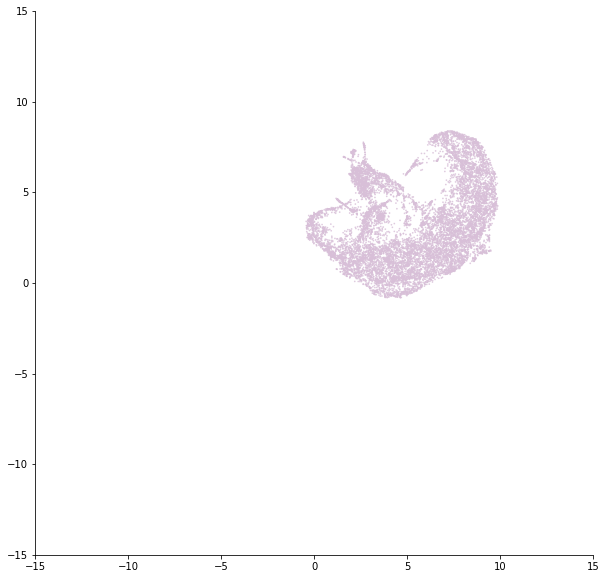

In [43]:
#decide to save or not
save_labeled_umap_plot = False

#show the umap plot
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)

if species in ['MU', 'MZ']: #color dictionary for MU and MZ - make points ignored by HDBSCAN the same color as the
                            #the ones it considered "clusters"
    HDBSCAN_color_dict = {0: 'thistle', 
                          -1:'thistle'}
else: #color dictionary for Peromyscus taxa
    HDBSCAN_color_dict = {0: 'thistle', 
                          1: 'deeppink'}

colmap = df_umap['label'].map(HDBSCAN_color_dict)

ax = plt.scatter(
    df_umap['umap1'],
    df_umap['umap2'],
    c = colmap,
    s = .5,
    alpha = .75, 
    cmap=None)

xlims = [-15,15]
ylims = [-15,15]
plt.xlim(xlims)
plt.ylim(ylims)
sns.despine()

if save_labeled_umap_plot:
    save_dir = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/features/spectrograms/amplitude_segmentation/final/umap_plots/'
    save_name = ('_').join([species,'final_amplitude_HDBSCAN_labeled_umap.jpeg'])
    plt.savefig(os.path.join(save_dir,save_name),dpi=600)

plt.show()


## Average spectrograms (Figure 1C middle/bottom)

In [44]:
#set the path to the vocalization clips and make sure it exists
clips_dir = os.path.join(amplitude_voc_clips, species)
assert os.path.exists(clips_dir)

#get path to each wav clip
all_files = [os.path.join(clips_dir,i) for i in df_umap['source_file']]

In [48]:
os.path.join(amplitude_voc_clips, species)

'/n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/clips/amplitude_segmented/development/final_20220817/vocalization_clips/MZ'

In [45]:
#set the spectrogram parameters
spec_params = {
    'min_freq': 5000, # minimum frequency
    'max_freq': 125000, # maximum frequency
    'nperseg': 512, # FFT
    'noverlap': 512 // 4, # FFT
    'spec_min_val': 0.5, # minimum log-spectrogram value - update from noise floors if noise_floors_path provided
    'fs': 250000, # audio samplerate
    'fill_value': 0.5,
    'max_duration':0.5, #set the max duration of each spectrogram to 0.5 seconds for all vocs and species
    'num_time_bins':256,
    'num_freq_bins':256,
    'spec_max_val':10
}

In [46]:
#generate the spectrograms

if species not in ['MU', 'MZ']: #if there are two clusters, generate spectrograms separately for each one
    
    label_0_files = [os.path.join(clips_dir,i) for i in df_umap['source_file'].loc[df_umap['label'] == 0]]
    label_1_files = [os.path.join(clips_dir,i) for i in df_umap['source_file'].loc[df_umap['label'] == 1]]
    
    #get the label 0 specs
    label_0_specs_list, _ = spectrogramming.specs_from_wavs(clips_dir = clips_dir, 
                                                            noise_floors_path=noise_floors_path ,
                                                            species = None, 
                                                            filtered_clips = label_0_files,
                                                            noise_floor = None,
                                                            spec_params=spec_params, 
                                                            num_to_process = 'all')

    #get the label 1 specs
    label_1_specs_list, _ = spectrogramming.specs_from_wavs(clips_dir = clips_dir, 
                                                            noise_floors_path=noise_floors_path ,
                                                            species = None, 
                                                            filtered_clips = label_1_files,
                                                            noise_floor = None,
                                                            spec_params=spec_params, 
                                                            num_to_process = 'all')


else:
    #get all the specs
    all_specs_list, _ = spectrogramming.specs_from_wavs(clips_dir = clips_dir, 
                                                        noise_floors_path=noise_floors_path, 
                                                        species = None, 
                                                        filtered_clips = all_files,
                                                        noise_floor = None,
                                                        spec_params=spec_params, 
                                                        num_to_process = 'all')


generating specs from the paths in the list filtered_clips...
processesing using the noise floors provided in noise_floors_path...
making spectrograms...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12045/12045 [04:21<00:00, 46.07it/s]

done.


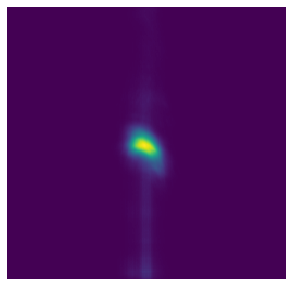

In [50]:
save = False

############################################################################################################

if species not in ['MU', 'MZ']: 
    
    #average the spectrograms you just generated
    label0_spec_avg = spectrogramming.spec_avg_from_list(label_0_specs_list)
    label1_spec_avg = spectrogramming.spec_avg_from_list(label_1_specs_list)

    #set up the figure
    fig, axes = plt.subplots(nrows=2, 
                             ncols=1, 
                             figsize=(5,10))
    
    
    #plot label 0 average
    axes[0].set_axis_off()
    axes[0].get_xaxis().set_visible(False)
    axes[0].get_yaxis().set_visible(False)
    axes[0].matshow(label0_spec_avg, interpolation="none", aspect="auto", cmap='viridis', origin="lower")
    
    #plot label 1 average
    axes[1].set_axis_off()
    axes[1].get_xaxis().set_visible(False)
    axes[1].get_yaxis().set_visible(False)
    axes[1].matshow(label1_spec_avg, interpolation="none", aspect="auto", cmap='viridis', origin="lower")
    
    #save 
    if save:
        save_dir = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/features/spectrograms/amplitude_segmentation/final/umap_plots/'
        save_name = ('_').join([species,'_HDBSCAN_all_vocs_common_duration.jpeg'])
        plt.savefig(fname=save_dir+save_name, dpi=600)
    
else: 
    
    #average the spectrograms you just generated
    all_spec_avg = spectrogramming.spec_avg_from_list(all_specs_list)

    #set up the figure
    fig, axes = plt.subplots(nrows=1, 
                             ncols=1, 
                             figsize=(5,5))
    
    
    #plot label 0 average
    axes.set_axis_off()
    axes.get_xaxis().set_visible(False)
    axes.get_yaxis().set_visible(False)
    axes.matshow(all_spec_avg, interpolation="none", aspect="auto", cmap='viridis', origin="lower")

    #save 
    if save:
        save_dir = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/features/spectrograms/amplitude_segmentation/final/umap_plots/'
        save_name = ('_').join([species,'_HDBSCAN_all_vocs_common_duration.jpeg'])
        plt.savefig(fname=save_dir+save_name, dpi=600)
    
    

## PCA of acoustic features (Figure 1 panel D)

### set color palettes

In [225]:
#collect the coustic features into a single csv

species_color_dict = {'BW':'steelblue',
                      'NB': 'dodgerblue',
                      'BK': 'darkblue',
                      'SW': 'blue',
                      'PO': 'orange',
                      'LO': 'gold',
                      'GO': 'green',
                      'LL': 'forestgreen',
                      'MU': 'mediumspringgreen', 
                      'MZ': 'turquoise'}

genus_color_dict = {'BW':'black',
                    'NB': 'black',
                    'BK': 'black',
                    'SW': 'black',
                    'PO': 'black',
                    'LO': 'black',
                    'GO': 'black',
                    'LL': 'black',
                    'MU': 'mediumspringgreen', 
                    'MZ':'turquoise'}

voc_name_color_dict = {'cry': 'deeppink', 
                       'whistle': 'thistle'}

HDBSCAN_color_dict = {0: 'thistle', 
                      1: 'deeppink', 
                      -1:'thistle'}

### set metadata and wableR acoustic features

In [89]:
#info about the vocalizer
metadata = ['species',
           'individual',
           'sex',
           'age', 
           'source_file',
           'label', 
            'weight_mg', 
            'removal_flag', 
            'genus']

#basic summary statistics calculated by warbleR
base_features = ['duration',
                 'time.median', 
                 'time.Q25', 
                 'time.Q75', 
                 'time.IQR', 
                 'meanfreq', 
                 'freq.median', 
                 'freq.Q25', 
                 'freq.Q75', 
                 'freq.IQR', ]

#additional features calculated by warbleR
extra_features = ['meanpeakf', 
                  'dfslope', 
                  'enddom', 
                  'startdom', 
                  'modindx', 
                  'dfrange', 
                  'sfm', 
                  'entropy',  
                  'sp.ent', 
                  'time.ent', 
                  'sd',                  
                  'meandom', 
                  'mindom', 
                  'maxdom', 
                  'skew', 
                  'kurt']


### get/clean the features and UMAP cluster labels for all species

In [204]:
#get umap cluster labels
print('getting umap HDBSCAN labels...')
umap_labels = os.path.join(amplitude_umap_HDBSCAN_labeled,'all_species_HDBSCAN_labels.csv')
umap_df = pd.read_csv(umap_labels)

#get features
print('getting features...')
features_path = os.path.join(amplitude_acoustic_features,'all_species_warbler_features.csv')
features_df = pd.read_csv(features_path)

#remove 85 MU "vocalizations" that are recording artefacts (not in umap embedding)
dropped = features_df['source_file'].loc[~features_df['source_file'].isin(umap_df['source_file'])]
features_df = features_df.loc[~features_df['source_file'].isin(dropped)]

#remove vocalizations that have nan for at least one acoustic feature (all of these are from MU)
nans = features_df['source_file'].iloc[pd.isnull(features_df).any(1).to_numpy().nonzero()]
features_df = features_df.loc[~features_df['source_file'].isin(nans)].sort_values(by='source_file').reset_index(drop=True)
umap_df = umap_df.loc[~umap_df['source_file'].isin(nans)].sort_values(by='source_file').reset_index(drop=True)

#make sure the source files are identical and merge
print('merging...')
assert umap_df['source_file'].equals(features_df['source_file'])
merged_df = features_df.merge(umap_df, on='source_file')

print('done.')

getting umap HDBSCAN labels...
getting features...
254460    MU_31063x31066_ltr2_pup7_ch8_4400_f_339_305_fr...
254466    MU_31063x31066_ltr2_pup7_ch8_4400_f_339_305_fr...
254591    MU_31063x31066_ltr2_pup7_ch8_4400_f_339_305_fr...
254596    MU_31063x31066_ltr2_pup7_ch8_4400_f_339_305_fr...
266877    MU_31873x31877_ltr0_pup1_ch1_3200_m_351_261_fr...
Name: source_file, dtype: object
merging...
done.


### do PCA

In [207]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

#get the features
features_set = base_features+extra_features
pca_df = features_df[features_set]

# Standardizing the features
standardized_features = StandardScaler().fit_transform(pca_df)

#2 component PCA
print('doing PCA...')
pca = PCA(n_components = 2)
pca_embedding = pca.fit_transform(standardized_features)
print('\texplained variance by PC:', pca.explained_variance_ratio_)
print('\ttotal variance explained:', sum(pca.explained_variance_ratio_))

#add to features_df
features_df['pc_1'] = pca_embedding[:,0]
features_df['pc_2'] = pca_embedding[:,1]

print('done.')

doing PCA...
	explained variance by PC: [0.51093306 0.11144792]
	total variance explained: 0.6223809859380659
done.


### get PCA loadings

In [208]:
loadings = pd.DataFrame(pca.components_.T, columns=['pc1', 'pc2'], index=df_pca.columns)
loadings['pc1'] = np.abs(loadings['pc1'])
loadings['pc2'] = np.abs(loadings['pc2'])
loadings = loadings.sort_values(by = ['pc1'], ascending=False)

### plot

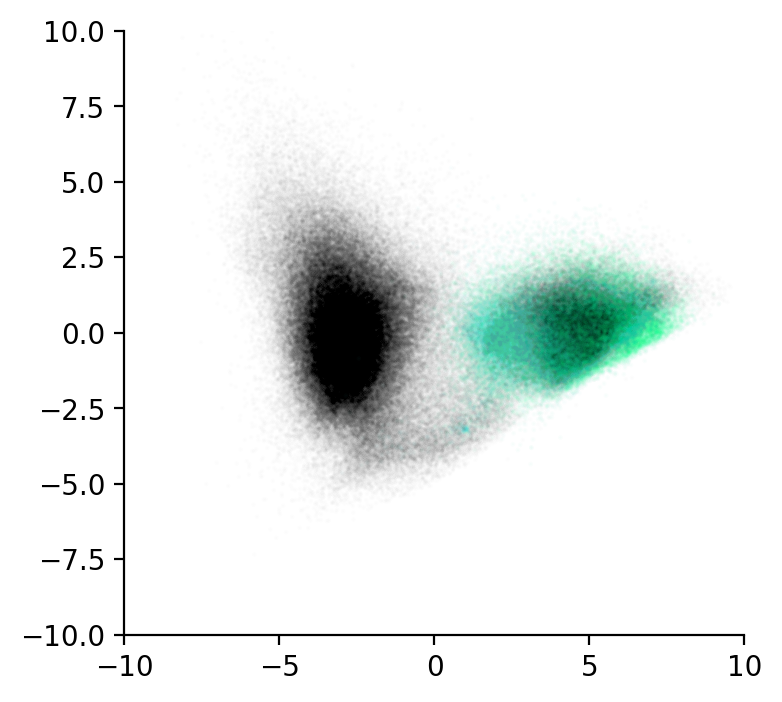

In [209]:
fig = plt.figure(figsize = [4,4], dpi= 200)
ax1 = fig.add_subplot(1,1,1)

colors = features_df['species'].map(genus_color_dict)

#plot Peromyscus
ax1.scatter(features_df['pc_1'].loc[~features_df['species'].isin(['MU', 'MZ'])], 
            features_df['pc_2'].loc[~features_df['species'].isin(['MU', 'MZ'])],
            c= features_df['species'].loc[~features_df['species'].isin(['MU', 'MZ'])].map(genus_color_dict),
            alpha = .0075, 
            s=.5)

#plot Mus
ax1.scatter(features_df['pc_1'].loc[features_df['species'].isin(['MU', 'MZ'])], 
            features_df['pc_2'].loc[features_df['species'].isin(['MU', 'MZ'])],
            c= features_df['species'].loc[features_df['species'].isin(['MU', 'MZ'])].map(genus_color_dict),
            alpha = .02, 
            s=.5)

ax1.set_xlim([-10,10])
ax1.set_ylim([-10,10])

sns.despine()

## Violin Plots of Acoustic Features by Species (Figure 1E)

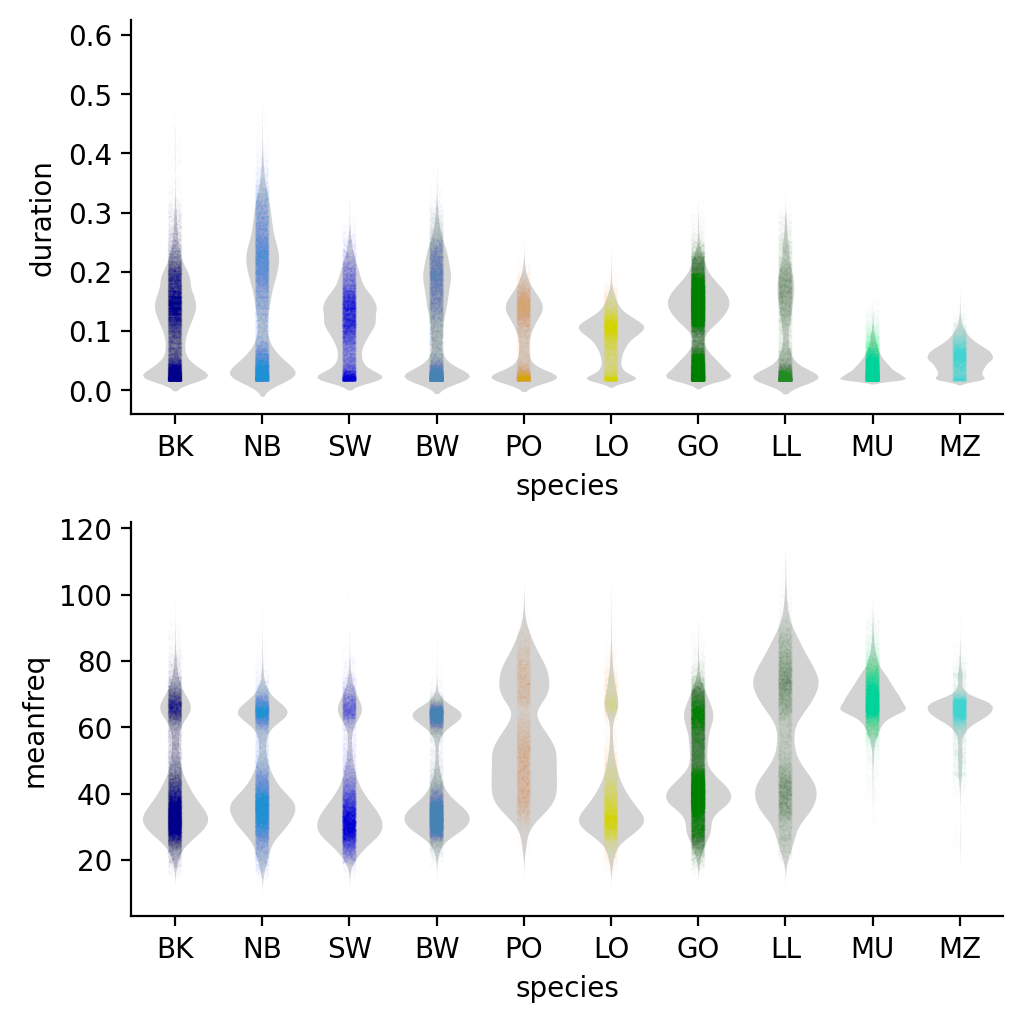

In [210]:

#set up the figures
fig = plt.figure(figsize = [5,5], constrained_layout=True, dpi=200)
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)
order = ['BK', 'NB', 'SW', 'BW', 'PO', 'LO', 'GO', 'LL', 'MU', 'MZ']

#plot the dots
sns.stripplot(data = features_df, ax = ax1, y='duration', x='species', hue = 'species', alpha=.01, s=.75, jitter=.075, order=order, palette = species_color_dict)
sns.stripplot(data = features_df, ax = ax2, y='meanfreq',x='species', hue = 'species', alpha=.01, s=.75, jitter=.075, order=order, palette = species_color_dict)

#plot the violins
sns.violinplot(data = features_df, ax = ax1, y='duration', x='species', scale = 'width', width = .75, alpha=1, order=order, inner=None, color = 'lightgray', linewidth=0)
sns.violinplot(data = features_df, ax = ax2, y='meanfreq', x='species', scale = 'width', width = .75, alpha=1, order=order, inner=None, color = 'lightgray', linewidth=0)

#remove the unecessary boundaries and legends
sns.despine()
ax1.legend([],[], frameon = False)
ax2.legend([],[], frameon = False)

## Hierarchical Clustering of Acoustic Features (Figure 1 panel F)

### sample the data

In [230]:
from sklearn.preprocessing import MinMaxScaler

#set seed for reproducible sampling
seed = 123456

#get the features
features_set = base_features+extra_features

#sample 50,000 vocalizations (otherwise too memory intensive)
cluster_df = merged_df.sample(n=50000, random_state=seed)
print('sampled',len(cluster_df),'vocalizations...')

#scale the columns 
print('scaling...')
standardized_features = pd.DataFrame(MinMaxScaler().fit_transform(cluster_df[features_set]), columns = features_set, index=cluster_df.index)
standardized_features = standardized_features[features_set]

print('done.')

sampled 50000 vocalizations...
scaling...
done.


### cluster

In [231]:
from sklearn.cluster import AgglomerativeClustering, KMeans

#define the distance below which leaves will not be merged
distance_threshold = 90

#define the clustering model to use
clusterer = AgglomerativeClustering(n_clusters=None, 
                                    affinity='euclidean', 
                                    linkage='ward', 
                                    compute_full_tree=True, 
                                    distance_threshold = distance_threshold)

#use it
print('clustering...')
clusterer.fit_predict(standardized_features)

#get clustering results
cluster_labels = clusterer.labels_
num_clusters = clusterer.n_clusters_

print('done.')

clustering...
done.


### plot

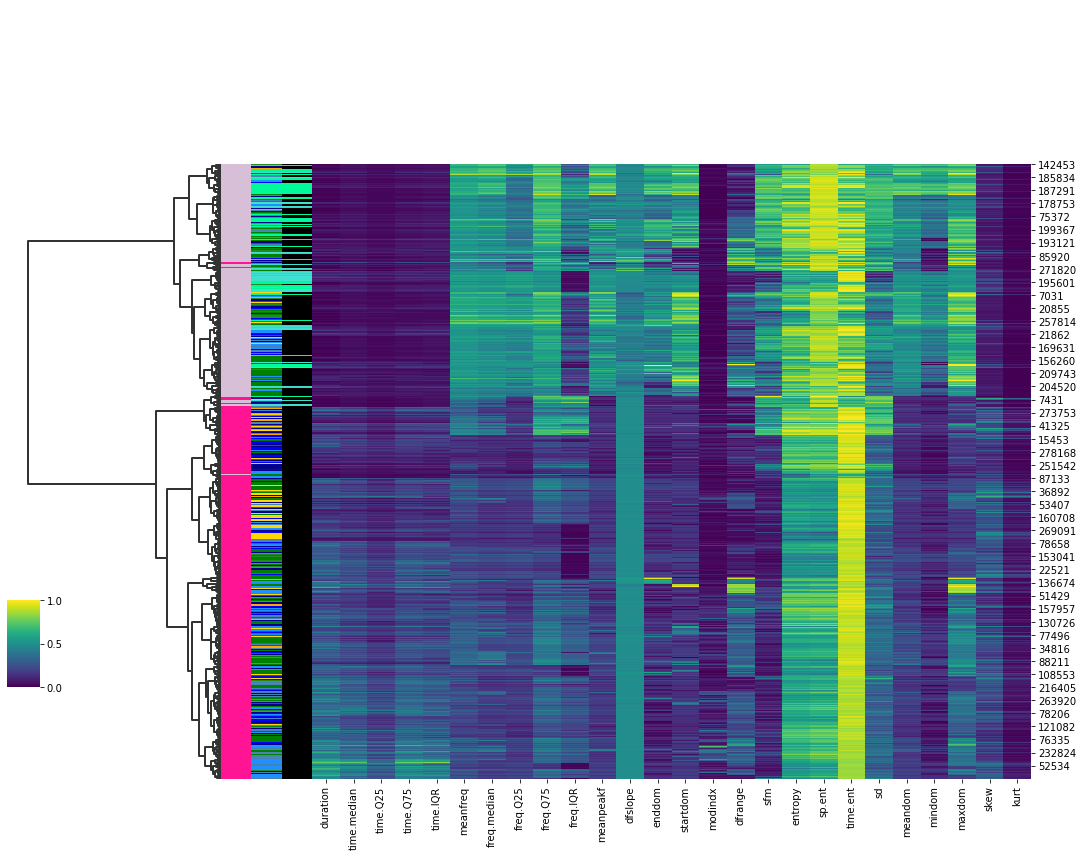

In [232]:
#may take a few minutes

#set the colors
voc_colmap = cluster_df['label'].map(HDBSCAN_color_dict)
species_colmap = cluster_df['species_x'].map(species_color_dict)
genus_colmap = cluster_df['species_x'].map(genus_color_dict)
row_colors = [voc_colmap, species_colmap, genus_colmap]

#plot
sns.clustermap(standardized_features,
               method = 'ward', 
               cmap = 'viridis', 
               col_cluster=False,
               figsize = (15, 12),
               cbar_pos=(0, .2, .03, .1),
               row_colors = row_colors, 
               mask = None, 
               colors_ratio=.03, 
               tree_kws={'linewidth':2})


# Figure 2

## get model to predict vocalization types (cry, USV, non-vocal)

In [13]:
#path to model for labeling amplitude segmented vocalizations as cry, scratch or whistle
voc_type_model_path = os.path.join(models_root,'voc_type_classifiers', '20230116_084254', 'random_forest_20230116_084254_voc_type_model.pkl')
voc_type_params_path = os.path.join(models_root,'voc_type_classifiers', '20230116_084254', 'random_forest_20230116_084254_params')

#load the model
voc_type_model = pickle.load(open(voc_type_model_path, 'rb'))

#load the training parameters
model_params = parameters.load_parameters(save_dir=os.path.split(voc_type_params_path)[0], 
                                          save_name=os.path.split(voc_type_params_path)[1])


loaded parameters from:
	 /n/hoekstra_lab_tier1/Users/njourjine/manuscript/models/random_forest/voc_type_classifiers/20230116_084254/random_forest_20230116_084254_params


## get/clean features

In [240]:
#get umap cluster labels
print('getting umap HDBSCAN labels...')
umap_labels = os.path.join(amplitude_umap_HDBSCAN_labeled,'all_species_HDBSCAN_labels.csv')
umap_df = pd.read_csv(umap_labels)

#get features
print('getting features...')
features_path = os.path.join(amplitude_acoustic_features,'all_species_warbler_features.csv')
features_df = pd.read_csv(features_path)

#remove 85 MU "vocalizations" that are recording artefacts (not in umap embedding)
dropped = features_df['source_file'].loc[~features_df['source_file'].isin(umap_df['source_file'])]
features_df = features_df.loc[~features_df['source_file'].isin(dropped)]

#remove vocalizations that have nan for at least one acoustic feature (all of these are from MU)
nans = features_df['source_file'].iloc[pd.isnull(features_df).any(1).to_numpy().nonzero()]
features_df = features_df.loc[~features_df['source_file'].isin(nans)].sort_values(by='source_file').reset_index(drop=True)
umap_df = umap_df.loc[~umap_df['source_file'].isin(nans)].sort_values(by='source_file').reset_index(drop=True)

#make sure the source files are identical and merge
print('merging...')
assert umap_df['source_file'].equals(features_df['source_file'])
merged_df = features_df.merge(umap_df, on='source_file')
assert(merged_df['species_x'].equals(merged_df['species_y']))
merged_df = merged_df.rename(columns={'species_x':'species'}).drop(columns=['species_y'])
merged_df['pup'] = [i.split('_clip')[0] for i in merged_df['source_file']]

#drop pups whose recordings were found to contain artefacts (vertical lines caused by data transfer issue) during annotation
pups_to_drop = ['BK_26464x25680_ltr4_pup7_ch8_4500_f_355_318_fr0_p7_2021-11-24_09-42-41',
                'BK_26464x25680_ltr4_pup7_ch8_4500_f_355_318_fr0_p7_2021-11-24_09-42-41',
                'GO_24860x23748_ltr2_pup4_ch5_4700_m_324_292_fr0_p9_2021-10-02_12-35-01',
                'GO_23883x23084_ltr2_pup4_ch6_6100_f_329_304_fr0_p11_2019-12-03_10-35-37']

print('dropping', len(merged_df.loc[merged_df['pup'].isin(pups_to_drop)]), 'vocs because they come from bad recordings...')
merged_df = merged_df.loc[~merged_df['pup'].isin(pups_to_drop)]
assert len(merged_df.loc[merged_df['pup'].isin(pups_to_drop)]) == 0

print('done.')

getting umap HDBSCAN labels...
getting features...
merging...
dropping 3488 vocs because they come from bad recordings...
done.


## predict vocalization labels from features 

In [241]:
#this takes a few minutes 

#get the features you trained on
for_prediction = merged_df[model_params['feature_set']]

#predict vocalization type from those features
predicted_labels = voc_type_model.predict(for_prediction)

#add them to the dataset
merged_df['predicted_label'] = predicted_labels
merged_df['predicted_label'] = ['USV' if i == 'whistle' else i for i in merged_df['predicted_label']]

/n/home10/jourjine/.conda/envs/manuscript/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


## general average spectrograms by label (Supplemental Figure ## Panel ##)

In [201]:
#make the spectrograms using a common max duration for all vocalizations and species (.5 seconds)
species_list = ['BK'] 

for species in species_list:
    print(species)
    max_dur = 0.5
    clips_dir = os.path.join(amplitude_voc_clips, species)
    cry_files = [os.path.join(clips_dir,i) for i in merged_df['source_file'].loc[merged_df['predicted_label'] == 'cry'].loc[merged_df['species'] == species]]
    USV_files = [os.path.join(clips_dir,i) for i in merged_df['source_file'].loc[merged_df['predicted_label'] == 'USV'].loc[merged_df['species'] == species]]
    scratch_files = [os.path.join(clips_dir,i) for i in merged_df['source_file'].loc[merged_df['predicted_label'] == 'scratch'].loc[merged_df['species'] == species]]

    spec_params = {
        'min_freq': 5000, # minimum frequency
        'max_freq': 125000, # maximum frequency
        'nperseg': 512, # FFT
        'noverlap': 512 // 4, # FFT
        'spec_min_val': 0.5, # minimum log-spectrogram value - update from noise floors dataframe if noise_floors_path provided
        'fs': 250000, # audio samplerate
        'downsample_by':2, #2 means take every other pixel from the original spectrogram - only usedin interpolate = False
        'log_resize_scaling_factor':None, 
        'fill_value': .5,
        'max_duration':max_dur,
        'num_time_bins':256,
        'num_freq_bins':256,
        'spec_max_val':10
    }


    print('getting cry specs...')
    cry_specs_list, _ = spectrogramming.specs_from_wavs(clips_dir = clips_dir, 
                                                            noise_floors_path=noise_floors_path ,
                                                            species = None, 
                                                            filtered_clips = cry_files,
                                                            noise_floor = None,
                                                            spec_params=spec_params, 
                                                            num_to_process = 'all')

    print('getting USV specs...')
    USV_specs_list, _ = spectrogramming.specs_from_wavs(clips_dir = clips_dir, 
                                                            noise_floors_path=noise_floors_path ,
                                                            species = None, 
                                                            filtered_clips = USV_files,
                                                            noise_floor = None,
                                                            spec_params=spec_params, 
                                                            num_to_process = 'all')

    print('getting scratch specs...')
    scratch_specs_list, _ = spectrogramming.specs_from_wavs(clips_dir = clips_dir, 
                                                            noise_floors_path=noise_floors_path ,
                                                            species = None, 
                                                            filtered_clips = scratch_files,
                                                            noise_floor = None,
                                                            spec_params=spec_params, 
                                                            num_to_process = 'all')

    


BK
getting cry specs...
generating specs from the paths in the list filtered_clips...
processesing using the noise floors provided in noise_floors_path...
making spectrograms...


 81%|█████████████████████████████████████████████████████████████████████                | 25825/31759 [11:58<02:45, 35.95it/s]


KeyboardInterrupt: 

In [ ]:
#show the specs
save = False

cry_spec_avg = spectrogramming.spec_avg_from_list(cry_specs_list)
USV_spec_avg = spectrogramming.spec_avg_from_list(USV_specs_list)
scratch_spec_avg = spectrogramming.spec_avg_from_list(scratch_specs_list)

fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)

print('making cry spec...')
ax1.set_axis_off()
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
ax1.set_title(species+' predicted cry n='+str(len(cry_specs_list)))
ax1.matshow(cry_spec_avg, interpolation="none", aspect="auto", cmap='viridis', origin="lower")

print('making USV spec...')
ax2.set_axis_off()
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
ax2.set_title(species+' predicted USV n='+str(len(USV_specs_list)))
ax2.matshow(USV_spec_avg, interpolation="none", aspect="auto", cmap='viridis', origin="lower")

print('making scratch spec...')
ax3.set_axis_off()
ax3.get_xaxis().set_visible(False)
ax3.get_yaxis().set_visible(False)
ax3.set_title(species+' predicted nonvocal n='+str(len(scratch_specs_list)))
ax3.matshow(scratch_spec_avg, interpolation="none", aspect="auto", cmap='viridis', origin="lower")

#save it
if save:
    save_dir = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/figures/figure_2/panels/'
    save_name = ('_').join([species,'RF_predicted_labels_20230127.jpeg'])
    print(save_dir+save_name)
    plt.savefig(fname=save_dir+save_name, dpi=600)

# del cry_spec_avg
# del USV_spec_avg
# del scratch_spec_avg
# del cry_specs_list
# del USV_specs_list
# del scratch_specs_list

In [215]:
merged_df['pup'].unique()[0]

'BK_24224x25894_ltr1_pup1_ch2_3700_m_358_302_fr0_p5_2021-10-22_11-05-10'

## aggregate labeled vocalizations by pup

In [224]:
#get the features to aggregate

#path to params (and features) for labeling amplitude segmented vocalizations as cry, scratch or whistle 
voc_type_params_path = os.path.join(models_root,'voc_type_classifiers', '20230116_084254', 'random_forest_20230116_084254_params')

#load the training parameters
model_params = parameters.load_parameters(save_dir=os.path.split(voc_type_params_path)[0], 
                                          save_name=os.path.split(voc_type_params_path)[1])

features_to_aggregate = model_params['feature_set']

loaded parameters from:
	 /n/hoekstra_lab_tier1/Users/njourjine/manuscript/models/random_forest/voc_type_classifiers/20230116_084254/random_forest_20230116_084254_params


In [242]:
#get the pups that you want to aggregate features from
print('getting pups...')

#exclude pups that have recording artefacts
pups_to_drop = ['NB_28306x26626_ltr1_pup4_ch5_5000_m_334_300_fr0_p11_2021-10-04_10-04-13.wav',
            'SW_29542x30031_ltr1_pup7_ch8_1600_m_348_263_fr0_p1_2022-01-05_10-54-58.wav',
            'BK_26464x25680_ltr4_pup7_ch8_4500_f_355_318_fr0_p7_2021-11-24_09-42-41.wav',
            'BK_26464x25680_ltr1_pup7_ch8_7300_m_305_301_fr0_p13_2021-08-24_09-30-30.wav',
            'GO_24860x23748_ltr2_pup4_ch5_4700_m_324_292_fr0_p9_2021-10-02_12-35-01.wav',
            'GO_23883x23084_ltr2_pup4_ch6_6100_f_329_304_fr0_p11_2019-12-03_10-35-37.wav']

#only aggregate features from pups who vocalized and only from non-IS deer mice
vocalizing_pups = [('.').join([i,'wav']) for i in sorted(merged_df['pup'].unique())]
source_list = [i for i in vocalizing_pups if i not in pups_to_drop and i.split('_')[0] not in ['MZ', 'MU', 'IS']]

#aggregate the data
print('getting aggregate features for each pup...')
all_pup_features, all_pup_metadata = features.aggregate_all_pups(source_list = source_list, 
                                                                 dataset = 'development', 
                                                                 features = features_to_aggregate, 
                                                                 features_df = merged_df) 
print('done.')

getting pups...
getting aggregate features for each pup...
done collecting metadata...
BK_24224x25894_ltr1_pup1_ch2_3700_m_358_302_fr0_p5_2021-10-22_11-05-10.wav
BK_24224x25894_ltr2_pup1_ch2_2200_m_336_267_fr0_p5_2021-11-16_09-52-17.wav
BK_24224x25894_ltr3_pup1_ch2_4400_m_338_313_fr0_p9_2021-12-16_10-42-08.wav
BK_24224x25894_ltr3_pup2_ch3_5200_f_335_326_fr0_p9_2021-12-16_10-42-08.wav
BK_24224x25894_ltr4_pup1_ch2_1900_m_337_269_fr0_p1_2022-01-16_10-39-22.wav
BK_24224x25894_ltr4_pup2_ch3_1900_m_336_263_fr0_p1_2022-01-16_10-39-22.wav
BK_24865x26049_ltr1_pup1_ch2_6700_m_309_328_fr0_p13_2021-10-12_10-42-01.wav
BK_24865x26049_ltr1_pup2_ch3_7000_f_319_321_fr0_p13_2021-10-12_10-42-01.wav
BK_24865x26049_ltr1_pup3_ch4_7800_m_300_316_fr0_p13_2021-10-12_10-42-01.wav
BK_24865x26049_ltr1_pup4_ch5_7800_f_325_330_fr0_p13_2021-10-12_10-42-01.wav
BK_24865x26049_ltr1_pup5_ch6_7200_m_321_316_fr0_p13_2021-10-12_10-42-01.wav
BK_24865x26049_ltr2_pup1_ch2_4700_f_327_331_fr0_p11_2021-11-03_10-08-14.wav
BK_2486

BW_28987x28928_ltr4_pup3_ch4_4700_m_330_315_fr0_p9_2021-12-25_09-50-00.wav
BW_28987x28928_ltr5_pup1_ch2_3400_m_360_280_fr0_p5_2022-01-16_11-30-21.wav
BW_28987x28928_ltr5_pup2_ch3_3100_f_360_282_fr0_p5_2022-01-16_11-30-21.wav
BW_28987x28928_ltr5_pup3_ch4_2800_m_352_289_fr0_p5_2022-01-16_11-30-21.wav
BW_28987x28928_ltr5_pup4_ch5_3000_f_350_291_fr0_p5_2022-01-16_11-30-21.wav
BW_28988x28929_ltr1_pup1_ch2_6000_f_316_315_fr0_p11_2021-07-20_10-00-42.wav
BW_28988x28929_ltr1_pup2_ch3_6300_f_315_304_fr1_p11_2021-07-20_10-00-42.wav
BW_28988x28929_ltr1_pup3_ch4_6100_f_311_295_fr0_p11_2021-07-20_10-00-42.wav
BW_28988x28929_ltr1_pup4_ch5_6300_f_299_305_fr1_p11_2021-07-20_10-00-42.wav
BW_28988x28929_ltr2_pup1_ch2_6300_m_310_319_fr0_p13_2021-10-26_10-30-05.wav
BW_28988x28929_ltr2_pup2_ch3_5900_f_309_309_fr0_p13_2021-10-26_10-30-05.wav
BW_28988x28929_ltr2_pup3_ch4_6300_f_280_308_fr0_p13_2021-10-26_10-30-05.wav
BW_28988x28929_ltr3_pup1_ch2_4400_m_343_315_fr0_p9_2021-11-15_10-19-25.wav
BW_28988x28929_ltr

GO_24860x23748_ltr2_pup1_ch2_3500_f_368_323_fr0_p5_2020-01-09_10-37-27.wav
GO_24860x23748_ltr2_pup1_ch2_4700_m_347_302_fr0_p9_2021-10-02_12-35-01.wav
GO_24860x23748_ltr2_pup2_ch3_4400_m_341_306_fr0_p9_2021-10-02_12-35-01.wav
GO_24860x23748_ltr2_pup2_ch4_3500_f_355_316_fr0_p5_2020-01-09_10-37-27.wav
GO_24860x23748_ltr2_pup3_ch4_4800_m_337_295_fr1_p9_2021-10-02_12-35-01.wav
GO_24860x23748_ltr2_pup3_ch5_3600_m_356_314_fr0_p5_2020-01-09_10-37-27.wav
GO_24860x23748_ltr2_pup4_ch6_3500_f_358_325_fr0_p5_2020-01-09_10-37-27.wav
GO_25787x25413_ltr1_pup1_ch4_3300_m_333_289_fr0_p7_2020-01-26_11-14-15.wav
GO_25787x25413_ltr1_pup2_ch2_4300_f_325_305_fr0_p7_2020-01-26_11-14-15.wav
GO_25787x25413_ltr1_pup3_ch3_4500_m_342_307_fr0_p7_2020-01-26_11-14-15.wav
GO_30890x31088_ltr1_pup1_ch2_2100_m_329_263_fr0_p1_2022-02-05_14-22-50.wav
GO_30890x31088_ltr1_pup2_ch3_2200_m_338_288_fr0_p1_2022-02-05_14-22-50.wav
GO_30890x31088_ltr1_pup3_ch4_2100_m_345_304_fr0_p1_2022-02-05_14-22-50.wav
GO_30890x31088_ltr1_pup4_

LO_29798x29672_ltr1_pup2_ch3_3800_m_348_307_fr0_p9_2021-11-18_14-23-34.wav
LO_29798x29672_ltr1_pup3_ch4_3900_m_352_307_fr0_p9_2021-11-18_14-23-34.wav
LO_29798x29672_ltr1_pup4_ch5_4300_m_353_316_fr0_p9_2021-11-18_14-23-34.wav
LO_29798x29672_ltr1_pup5_ch6_4200_f_346_316_fr0_p9_2021-11-18_14-23-34.wav
LO_29798x29672_ltr2_pup1_ch2_4500_f_325_321_fr0_p13_2021-12-18_15-11-52.wav
LO_29798x29672_ltr2_pup2_ch3_5200_m_323_326_fr0_p13_2021-12-18_15-11-52.wav
LO_29798x29672_ltr2_pup3_ch4_5100_f_324_320_fr0_p13_2021-12-18_15-11-52.wav
LO_29798x29672_ltr2_pup4_ch5_4600_m_317_325_fr0_p13_2021-12-18_15-11-52.wav
LO_29798x29672_ltr2_pup5_ch6_5100_f_336_329_fr0_p13_2021-12-18_15-11-52.wav
LO_29798x29672_ltr2_pup6_ch7_4800_f_318_318_fr0_p13_2021-12-18_15-11-52.wav
LO_29798x29672_ltr2_pup7_ch8_4300_m_321_315_fr0_p13_2021-12-18_15-11-52.wav
LO_29911x30128_ltr1_pup1_ch2_1800_m_356_287_fr0_p1_2021-12-31_15-35-17.wav
LO_29911x30128_ltr1_pup2_ch3_1400_m_341_262_fr0_p1_2021-12-31_15-35-17.wav
LO_29911x30128_ltr

PO_28315x28473_ltr2_pup3_ch4_4400_f_326_301_fr1_p9_2021-10-24_14-01-42.wav
PO_28315x28473_ltr3_pup1_ch2_4400_m_332_316_fr0_p11_2021-11-21_13-02-02.wav
PO_28315x28473_ltr3_pup2_ch3_4400_m_339_326_fr1_p11_2021-11-21_13-02-02.wav
PO_28315x28473_ltr3_pup3_ch4_4500_f_333_327_fr1_p11_2021-11-21_13-02-02.wav
PO_28315x28473_ltr3_pup4_ch5_4500_f_336_325_fr0_p11_2021-11-21_13-02-02.wav
PO_28315x28473_ltr3_pup5_ch6_4000_f_323_309_fr1_p11_2021-11-21_13-02-02.wav
PO_28582x28188_ltr1_pup1_ch2_3300_m_343_292_fr0_p7_2021-07-21_12-12-53.wav
PO_28582x28188_ltr1_pup2_ch3_3100_m_340_289_fr0_p7_2021-07-21_12-12-53.wav
PO_28582x28188_ltr2_pup1_ch2_2800_m_347_289_fr0_p5_2021-11-02_13-42-30.wav
PO_28582x28188_ltr2_pup2_ch3_3100_m_343_285_fr0_p5_2021-11-02_13-42-30.wav
PO_28582x28188_ltr2_pup3_ch4_2900_m_339_265_fr0_p5_2021-11-02_13-42-30.wav
PO_28582x28188_ltr3_pup1_ch2_4700_f_323_317_fr0_p13_2021-12-06_13-19-07.wav
PO_28582x28188_ltr3_pup2_ch3_5000_f_312_319_fr0_p13_2021-12-06_13-19-07.wav
PO_28582x28188_ltr

SW_31158x30632_ltr2_pup3_ch4_8300_m_306_330_fr0_p13_2021-12-28_10-52-35.wav
SW_31158x30632_ltr2_pup4_ch5_8200_m_321_329_fr0_p13_2021-12-28_10-52-35.wav
SW_31158x30632_ltr2_pup5_ch6_7700_m_313_325_fr0_p13_2021-12-28_10-52-35.wav
SW_31158x30632_ltr2_pup6_ch7_8200_m_312_340_fr0_p13_2021-12-28_10-52-35.wav
SW_31158x30632_ltr3_pup1_ch2_4000_m_359_323_fr0_p5_2022-03-05_11-34-33.wav
SW_31158x30632_ltr3_pup2_ch3_4300_m_349_323_fr0_p5_2022-03-05_11-34-33.wav
SW_31158x30632_ltr3_pup3_ch4_3900_m_348_302_fr0_p5_2022-03-05_11-34-33.wav
SW_31158x30632_ltr3_pup4_ch5_4100_f_353_310_fr0_p5_2022-03-05_11-34-33.wav
SW_31158x30632_ltr4_pup1_ch2_8200_m_328_336_fr0_p11_2022-04-28_11-37-30.wav
SW_31158x30632_ltr4_pup2_ch3_7500_f_338_346_fr0_p11_2022-04-28_11-37-30.wav
SW_31158x30632_ltr4_pup3_ch4_8200_f_323_337_fr0_p11_2022-04-28_11-37-30.wav
SW_31158x30632_ltr4_pup4_ch5_8400_m_330_323_fr0_p11_2022-04-28_11-37-30.wav
SW_31244x31358_ltr1_pup1_ch2_4600_m_355_312_fr0_p7_2022-03-03_09-53-27.wav
SW_31244x31358_lt

## get annotated vocalizations for species comparisons

## features PCA (Supplemental Figure ##)

### run PCA

### scatter plots

### violin plots

## species comparisons (Figure 2C)

# Figure 4 (cross foster experiments)

## collect data

## PCA

## plot

# Figure 5 (F1 and F2 experiments)

## collect data

## PCA

## plot

# Supplemental Figure ## (more UMAP)

## color UMAP by acoustic feature

In [51]:
#choose the directories you want and print the embeddings you have available to plot
coords_dir = amplitude_umap_HDBSCAN_labeled
coords_list = os.listdir(coords_dir)

print('coordinates available...')
for i in coords_list: 
    print(i)

coordinates available...
SW
BK
LL
LO
all_species_HDBSCAN_labels.csv
MU
PO
NB
all_species_HDBSCAN_labels.feather
MZ
BW
GO


In [142]:
#choose species decide what to save
species = 'BW'

save_umap_plot = False
save_labeled_umap_plot = False
save_label_verification = False

#load the coordinates
coords_path = glob.glob(coords_dir+species+'/*labeled.feather')[0]
df_umap = pd.read_feather(coords_path)

#just get the coordinates
df_umap_small = df_umap[['umap1', 'umap2', 'source_file', 'label']]


In [143]:
#merge UMAP coordinates with acoustic features

#the features csv for this species
features = pd.read_csv(glob.glob(os.path.join(amplitude_acoustic_features, species+'*'))[0])

#merge
df_umap_features = df_umap_small.merge(features, on= 'source_file')
df_umap_features['pup'] = [i.split('_clip')[0] for i in df_umap_features['source_file']]
df_umap_features['pupID'] = pd.factorize(df_umap_features['pup'])[0]
df_umap_features['age'] = [int(i.split('_')[10][1:]) for i in  df_umap_features['pup']]
df_umap_features['duration'] = df_umap_features['duration']*1000

/n/home10/jourjine/.conda/envs/manuscript/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.


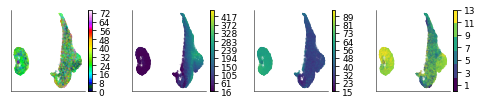

In [144]:
#plot
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib import cm
import matplotlib as mpl

save = False
save_dir = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/figures/figure_1/supplement/'


colors = ['pupID', 'duration', 'meanfreq', 'age']
df = df_umap_features
fontsize= 9

fig, axes = plt.subplots(nrows =1, 
                         ncols = len(colors), 
                         figsize = [8,1.5], 
                         constrained_layout=True, 
                         sharex=True, 
                         sharey=True)

fig.subplots_adjust(wspace=0.5)


for color, i in zip(colors, range(len(colors))):
    
    if color == 'pupID':
        cmap = 'gist_ncar'
    else:
        cmap = 'viridis'
    
    divider = make_axes_locatable(axes[i])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    
#     axes[i].set_xlim([-17,13])
#     axes[i].set_ylim([-10,20])
    
    im = axes[i].scatter(
        df['umap1'],
        df['umap2'],
        c = df[color],
        s = .1,
        alpha = .25, 
        cmap=cmap)
    
    for label in (axes[i].get_yticklabels() + axes[i].get_xticklabels()):
        label.set_fontname('Arial')
        label.set_fontsize(fontsize)
        
    for axis in ['top','bottom','left','right']:
        axes[i].spines[axis].set_linewidth(.5)
        
 
    if color == 'pupID':
        bounds = np.linspace(0, np.max(df['pupID']), np.max(df['pupID'])+1)
        cmap = cm.get_cmap('gist_ncar')
        norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
        cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), 
                     cax=cax, 
                     orientation='vertical')
        cbar.ax.tick_params(labelsize=9) 
        
    elif color == 'age':
        bounds = np.linspace(0, 13, 7)
        cmap = cm.get_cmap('viridis')
        norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
        cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), 
                     cax=cax, 
                     orientation='vertical', 
                     ticks = [1, 3, 5, 7, 9, 11, 13])
        cbar.ax.tick_params(labelsize=9) 
        
    elif color == 'duration':
        bounds = np.round(np.linspace(np.min(df[color]), np.max(df[color])), decimals=0)
        cmap = cm.get_cmap('viridis')
        norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
        cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), 
                     cax=cax, 
                     orientation='vertical')
        cbar.ax.tick_params(labelsize=9) 
        
    elif color == 'meanfreq':
        bounds = np.round(np.linspace(np.min(df[color]), np.max(df[color])), decimals=0)
        cmap = cm.get_cmap('viridis')
        norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
        cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), 
                     cax=cax, 
                     orientation='vertical')
        cbar.ax.tick_params(labelsize=9) 

    axes[i].xaxis.set_tick_params(width=.5)
    axes[i].yaxis.set_tick_params(width=.5)
    axes[i].yaxis.set_tick_params(width=.5)
    axes[i].set_xticks([], [])
    axes[i].set_yticks([], [])

    sns.despine()


## get vocalization examples from UMAP

In [145]:
#set seeds for reproducible sampling

if species == 'SW':
    USV_seed = 33333
    cry_seed= 54321
elif species == 'BK':
    USV_seed = 987654
    cry_seed = 12345
elif species == 'LO':
    USV_seed = 55555
    cry_seed = 12345678
elif species == 'NB':
    USV_seed = 222223
    cry_seed = 9876
elif species == 'BW':
    USV_seed = 1234567
    cry_seed= 54321
elif species == 'PO':
    USV_seed = 22222
    cry_seed= 87654321
elif species == 'GO':
    USV_seed = 1234567
    cry_seed= 123456
elif species == 'LL':
    USV_seed = 1234567
    cry_seed= 987654
elif species == 'MU':
    USV_seed = 123456789
elif species == 'MZ':
    USV_seed = 4444

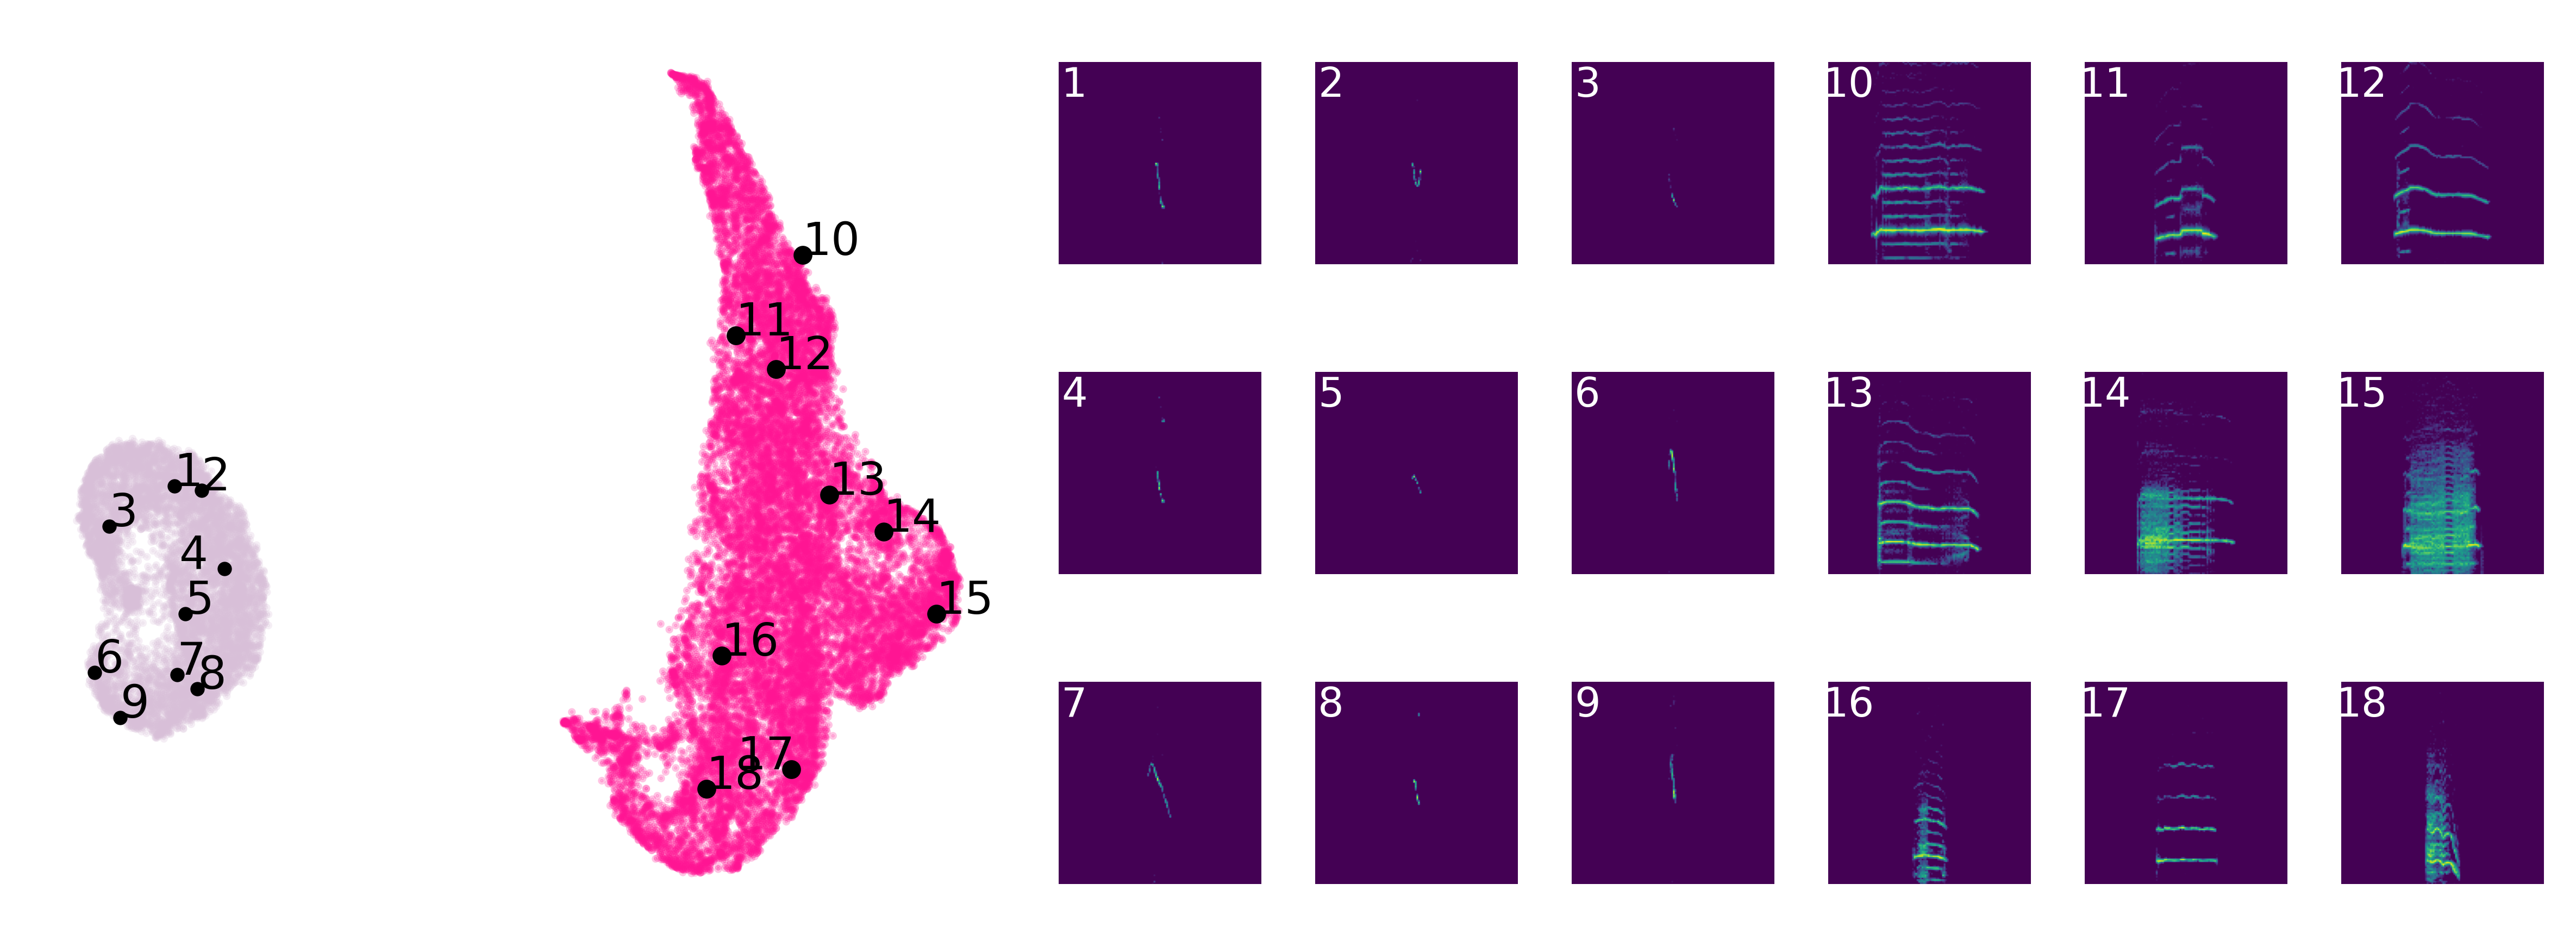

In [146]:
#plot

save=True

if species in ['MU', 'MZ']: 
    #set up the axes
    fig, axes = plt.subplot_mosaic(mosaic="AAAABCDEFG;AAAAHIJKLM;AAAANOPQRS", 
                                   figsize=[8,3], 
                                   layout='tight', 
                                   dpi=600)

    # #parameters
    label_color_dict = {1: 'deeppink', 0: 'thistle', -1:'thistle'}
    num_freq_bins=128
    num_time_bins=128
    dot_size = 10
    dot_alpha = 1

    #plot the umap
    axes["A"].scatter(
        df_umap['umap1'],
        df_umap['umap2'],
        c = df_umap['label'].map(label_color_dict),
        s = .5,
        alpha = .25, 
        cmap='viridis')

    USV_spec_axes = ["B", "C", "D", "H", "I", "J", "N", "O", "P"]
    cry_spec_axes = ["E", "F", "G", "K", "L", "M", "Q", "R", "S"]
    all_spec_axes  = USV_spec_axes + cry_spec_axes

    #remove ticks
    axes["A"].set_xticks([], [])
    axes["A"].set_yticks([], [])
    axes["A"].axis('off')
    sns.despine()
    for ax in all_spec_axes:
        axes[ax].set_xticks([], [])
        axes[ax].set_yticks([], [])
    fig.subplots_adjust(wspace=0, hspace = 0)

    #sample example vocalizations
    if species not in ['MU', 'MZ']:
        USV_examples = df_umap.loc[df_umap['label'] == 0].sample(n=9, random_state=USV_seed)
        cry_examples = df_umap.loc[df_umap['label'] == 1].sample(n=9, random_state=cry_seed)
    else:
        USV_examples = df_umap.sample(n=18, random_state=USV_seed)

    #overlay them on the umap as black dots
    axes["A"].scatter(
        USV_examples['umap1'],
        USV_examples['umap2'],
        c = 'black',
        s = dot_size,
        alpha = dot_alpha, 
        linewidth=0)

    #overlay them on the umap plot as black dots
    if species not in ['MU', 'MZ']:
        axes["A"].scatter(
            cry_examples['umap1'],
            cry_examples['umap2'],
            c = 'black',
            s = dot_size,
            alpha = dot_alpha)

    #label them so you know which spec goes with which axis
    USV_examples = USV_examples.sort_values(by='umap2', ascending=False)
    USV_examples['plot_axis'] = USV_spec_axes + cry_spec_axes

    txt = [1,2,3,4,5,6,7,8,9, 10,11,12,13,14,15,16,17,18]
    for txt, umap1, umap2 in zip(txt,USV_examples['umap1'], USV_examples['umap2']):
        if txt == 4:
            axes["A"].annotate(text=txt, xy=(umap1,  umap2), xytext=(-10,0), textcoords = 'offset points')
        elif txt == 7:
            axes["A"].annotate(text=txt, xy=(umap1,  umap2), xytext=(0,0), textcoords = 'offset points')
        else:
            axes["A"].annotate(text=txt, xy=(umap1,  umap2), xytext=(0,0), textcoords = 'offset points')

    txt = [1,2,3,4,5,6,7,8,9, 10,11,12,13,14,15,16,17,18]
    for ax,label in zip(all_spec_axes, txt):
        columns_to_drop = ['source_file', 'umap1', 'umap2', 'label', 'plot_axis']

        to_plot = USV_examples.loc[USV_examples['plot_axis'] == ax].drop(columns = columns_to_drop)

        img = np.array(to_plot).reshape((num_freq_bins, num_time_bins))
        axes[ax].axis('off')
        axes[ax].imshow(img, origin = 'lower', extent = (num_freq_bins, 0, num_time_bins, 0 ))

        axes[ax].text(118, 15, label, ha="center", va="center", color="w", fontsize=9, fontname='Arial')

else:
    
    #set up the axes
    fig, axes = plt.subplot_mosaic(mosaic="AAAABCDEFG;AAAAHIJKLM;AAAANOPQRS", 
                                   figsize=[8,3], 
                                   layout='tight', 
                                   dpi=600)

    # #parameters
    label_color_dict = {1: 'deeppink', 0: 'thistle', -1:'thistle'}



    num_freq_bins=128
    num_time_bins=128
    dot_size = 10
    dot_alpha = 1

    #plot the umap
    axes["A"].scatter(
        df_umap['umap1'],
        df_umap['umap2'],
        c = df_umap['label'].map(label_color_dict),
        s = .5,
        alpha = .25, 
        cmap='viridis')

    USV_spec_axes = ["B", "C", "D", "H", "I", "J", "N", "O", "P"]
    cry_spec_axes = ["E", "F", "G", "K", "L", "M", "Q", "R", "S"]

    #remove ticks
    axes["A"].set_xticks([], [])
    axes["A"].set_yticks([], [])
    axes["A"].axis('off')
    sns.despine()
    for ax in all_spec_axes:
        axes[ax].set_xticks([], [])
        axes[ax].set_yticks([], [])
    fig.subplots_adjust(wspace=0, hspace = 0)

    #sample example vocalizations
    USV_examples = df_umap.loc[df_umap['label'] == 0].sample(n=9, random_state=USV_seed)
    cry_examples = df_umap.loc[df_umap['label'] == 1].sample(n=9, random_state=cry_seed)

    #overlay them on the umap as black dots
    axes["A"].scatter(
        USV_examples['umap1'],
        USV_examples['umap2'],
        c = 'black',
        s = dot_size,
        alpha = dot_alpha, 
        linewidth=0)

    axes["A"].scatter(
        cry_examples['umap1'],
        cry_examples['umap2'],
        c = 'black',
        s = dot_size,
        alpha = dot_alpha)

    #label them so you know which spec goes with which axis
    USV_examples = USV_examples.sort_values(by='umap2', ascending=False)
    cry_examples = cry_examples.sort_values(by='umap2', ascending=False)
    USV_examples['plot_axis'] = USV_spec_axes
    cry_examples['plot_axis'] = cry_spec_axes

    #annotate the dots with numbers and move some of them so they aren't on top of other numbers
    txt = [1,2,3,4,5,6,7,8,9, 10,11,12,13,14,15,16,17,18]
    for txt, umap1, umap2 in zip(txt,USV_examples['umap1'], USV_examples['umap2']):

        if txt == 4:
            axes["A"].annotate(text=txt, xy=(umap1,  umap2), xytext=(-10,0), textcoords = 'offset points')
        elif txt == 7:
            axes["A"].annotate(text=txt, xy=(umap1,  umap2), xytext=(0,0), textcoords = 'offset points')
        else:
            axes["A"].annotate(text=txt, xy=(umap1,  umap2), xytext=(0,0), textcoords = 'offset points')

    txt = [10,11,12,13,14,15,16,17,18]
    for txt, umap1, umap2 in zip(txt,cry_examples['umap1'], cry_examples['umap2']):
        if txt == 17:
            axes["A"].annotate(text=txt, xy=(umap1,  umap2), xytext=(-12,0), textcoords = 'offset points')
        else:
            axes["A"].annotate(text=txt, xy=(umap1,  umap2), xytext=(0,0), textcoords = 'offset points')

    #put the USV spectrograms on their axes
    txt = [1,2,3,4,5,6,7,8,9]
    for ax,label in zip(USV_spec_axes, txt):
        
        #get the spectrogram
        columns_to_drop = ['source_file', 'umap1', 'umap2', 'label', 'plot_axis']
        to_plot = USV_examples.loc[USV_examples['plot_axis'] == ax].drop(columns = columns_to_drop)
        img = np.array(to_plot).reshape((num_freq_bins, num_time_bins))      
        
        #plot
        axes[ax].axis('off')
        axes[ax].imshow(img, origin = 'lower', extent = (num_freq_bins, 0, num_time_bins, 0 ))
        axes[ax].text(118, 15, label, ha="center", va="center", color="w", fontsize=9, fontname='Arial')

    #put the cry spectrograms on their axes
    txt = [10,11,12,13,14,15,16,17,18]
    for ax, label in zip(cry_spec_axes, txt):
        
        #get the spectrogram
        columns_to_drop = ['source_file', 'umap1', 'umap2', 'label', 'plot_axis']
        to_plot = cry_examples.loc[cry_examples['plot_axis'] == ax].drop(columns = columns_to_drop)
        img = np.array(to_plot).reshape((num_freq_bins, num_time_bins))
        
        #plot
        axes[ax].axis('off')
        axes[ax].imshow(img, origin = 'lower', extent = (num_freq_bins, 0, num_time_bins, 0 ))
        axes[ax].text(115, 15, label, ha="center", va="center", color="w", fontsize=9, fontname='Arial')

if save:
    save_dir = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/figures/figure_1/supplement'
    save_name = ('_').join([species,'spec_examples_20230125'+'.jpeg'])
    plt.savefig(os.path.join(save_dir,save_name),dpi=600)
    


# Supplemental Figure ## (weights and heat loss)

# Supplemental Figure ## (inter-onset intervals)